In [8]:
%matplotlib inline

import dill
from collections import defaultdict, Counter
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import digamma,gammaln


In [9]:
#read the training files

##english
train_e = 'training/hansards.36.2.e'
test_e = 'testing/test/test.e'
dev_e = 'validation/dev.e'
# train_e = 'training/eng.e'

##french
train_f = 'training/hansards.36.2.f'
test_f = 'testing/test/test.f'
dev_f = 'validation/dev.f'
# train_f = 'training/fra.f'

null = ['0NULL']

with open(train_e) as e:
    sentences_e = [null + l.split() for l in e.readlines()]

with open(test_e) as e:
    for l in e.readlines():
         sentences_e.append(null + l.split())

with open(dev_e) as e:
    for l in e.readlines():
         sentences_e.append(null + l.split())

    
with open(train_f) as f:
    sentences_f = [l.split() for l in f.readlines()]

with open(test_f) as f:
    for l in f.readlines():
         sentences_f.append(l.split())

with open(dev_f) as f:
    for l in f.readlines():
         sentences_f.append(l.split())

no_sentences = len(sentences_e)
print(no_sentences)

231648


In [10]:
w2i_e = defaultdict(lambda: len(w2i_e)) #word 2 index english corpus
i2w_e = dict() #index 2 word english corpus
    
w2i_f = defaultdict(lambda: len(w2i_f))  #word 2 index french corpus
i2w_f = dict() #index 2 word french corpus

#here we create w2i and i2w dictionaries for french and english
for i in range (10):
    sent_e = sentences_e[i]
    sent_f = sentences_f[i]
    
    for word_e in sent_e:
        i2w_e[w2i_e[word_e.lower()]] = word_e.lower()
    
    for word_f in sent_f:
        i2w_f[w2i_f[word_f.lower()]] = word_f.lower()

french_vocab = len(w2i_f)
english_vocab = len(w2i_e)

print(french_vocab)
print(english_vocab)

43
41


In [12]:
import warnings
warnings.filterwarnings('error')

this is iteration 0
-944.963845793 -770.334949436
-1715.29879523
this is iteration 1
-959.589102352 -734.832918776
-1694.42202113
this is iteration 2
-956.414460902 -629.745141946
-1586.15960285
this is iteration 3
-955.977606842 -605.814902674
-1561.79250952
this is iteration 4
-953.212384158 -581.791563409
-1535.00394757
this is iteration 5
-950.03311188 -560.739835064
-1510.77294694
this is iteration 6
-958.084773228 -528.335595177
-1486.42036841
this is iteration 7
-967.314132871 -528.326611547
-1495.64074442
this is iteration 8
-975.071387797 -528.321064844
-1503.39245264
this is iteration 9
-981.774055019 -528.316960477
-1510.0910155


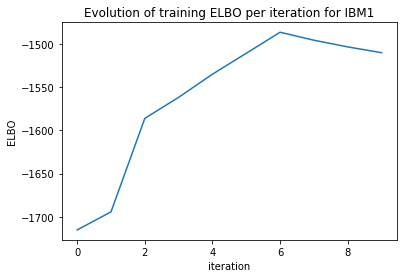

In [13]:
#IBM model 1 with Variational Bayes 
lambda_values_ef = defaultdict(lambda: defaultdict(int))
sum_lambda = defaultdict(int)
lambdas = defaultdict(lambda: defaultdict(int))
alpha_value = 0.01
s_total = defaultdict(int)

num_sentences = 10
french_voc = []
english_voc = []
for i in range (num_sentences):
    sent_e = sentences_e[i]
    sent_f = sentences_f[i]
    
    for word_f in sent_f:
        french_voc.append(word_f.lower())
        for word_e in sent_e:
            #initialize the lambda values as alpha (0.001)
            thetas[word_f.lower()][word_e.lower()] = alpha_value
            english_voc.append(word_e.lower())
        

french_voc = list(set(french_voc))
english_voc = list(set(english_voc))

ELBO_list = []
    
num_iterations = 10

#while not converged 
for k in range(num_iterations):
    
    print("this is iteration",k)
    

    lambda_values_ef = defaultdict(lambda: defaultdict(lambda: alpha_value))
    
   
    for sent in range(num_sentences):
        
        sent_e = sentences_e[sent]
        sent_f = sentences_f[sent]
        
        #Here we compute the sum over the lambdas for a french words
        #count for lambdas
        for word_f in sent_f:
            
            s_total[word_f.lower()] = 0
        
            for word_e in sent_e:
        
                s_total[word_f.lower()] += thetas[word_f.lower()][word_e.lower()]
        
        
            for word_e in sent_e:
                    
                delta = thetas[word_f.lower()][word_e.lower()] / s_total[word_f.lower()]
                
                
                lambda_values_ef[word_f.lower()][word_e.lower()] = alpha_value + delta
        
               
                
        for word_e in english_voc:
            
            s_total[word_f.lower()] = 0
            
            for word_f in french_voc:
                
                sum_lambda[word_e.lower()] += lambda_values_ef[word_f.lower()][word_e.lower()]

        #update thetas 
        for word_f in sent_f:
            
            for word_e in sent_e:
                
                thetas[word_f.lower()][word_e.lower()] = np.exp(digamma(lambda_values_ef[word_f.lower()][word_e.lower()]) - digamma(sum_lambda[word_e.lower()]))
               
            
    #Compute the ELBO
    ELBO = 0
    likelihood = 0
    
    #Compute the expected value of the sufficient statistic 
    for sent in range(num_sentences):
        
        sent_e = sentences_e[sent]
        sent_f = sentences_f[sent]
        
        l = len(sent_e) #includes null
        m = len(sent_f)
        
        const = -m * np.log(l)
        
        sent_likelihood = 0 

        for i in range(m):

            word_likelihood = -9999

            best_j = -1 #to be set after the loop below

            for j in range(l):

                temp_likelihood = thetas[sent_f[i].lower()][sent_e[j].lower()]
                
                if word_likelihood == -9999 or temp_likelihood > word_likelihood:

                    word_likelihood = temp_likelihood
                    best_j = j #we can use this part for decoding later
                
            sent_likelihood += np.log(word_likelihood) + const
    
        likelihood += sent_likelihood
    
    #KL-divergence part
    KL = 0
    for e in english_voc:
        
        for f in french_voc:
            
            KL += thetas[f][e] * (alpha_value - lambda_values_ef[f][e]) + gammaln(lambda_values_ef[f][e]) - gammaln(alpha_value)
            
            
        KL += gammaln(alpha_value*len(french_voc))
        
        
        summed_lambdas = 0 
        
        for f in french_voc:
            summed_lambdas += lambda_values_ef[f][e]
        
        KL -= gammaln(summed_lambdas)
    
    print(likelihood, KL)
    ELBO = likelihood + KL
    print(ELBO)
    
    ELBO_list.append(ELBO)

iteration= list(range(len(ELBO_list)))

plt.plot(iteration, ELBO_list)
plt.xlabel("iteration")
plt.ylabel('ELBO')
plt.title('Evolution of training ELBO per iteration for IBM1')
plt.savefig("EM_IBM_VI.png")
plt.show()

In [60]:
#Decoding with IBM model 1 with VBI
#we try to find the most probable alignment given the translation 
#probabilities that were trained with the EM steps
#for each word in a sentence, find highest theta values

def write_naacl(filename):

    naaclfile = open(filename,"w") 

    for sent in range(num_val_sentences):
        sent_e = val_sentences_e[sent]
        sent_f = val_sentences_f[sent]


        l = len(sent_e) #includes null
        m = len(sent_f)

        for f in range(m):
            best_prob = 0
            best_j = 0
            for e in range(l):
                if thetas[sent_f[f].lower()][sent_e[e].lower()] > best_prob:
                    best_prob = thetas[sent_f[f].lower()][sent_e[e].lower()]
                    best_j = e
            if best_j != 0:
                naaclfile.write(str(sent+1) + " " + str(best_j) + " " + str(f+1) + " S" + "\n")
    naaclfile.close()

In [61]:
dev_e = 'validation/dev.e'
test_e = 'testing/test/test.e'
dev_f = 'validation/dev.f'
test_f = 'testing/test/test.f'

with open(test_e) as e:
    val_sentences_e = [null + l.split() for l in e.readlines()]
with open(test_f) as f:
    val_sentences_f = [l.split() for l in f.readlines()]

num_val_sentences = len(val_sentences_e)

In [62]:
write_naacl('ibm_vi_100.txt')

2 . 1 2
. 2 2 1
2 . 1 2
. 2 2 1
oh 0NULL 1 0
, , 2 2
oh 0NULL 3 0
! 0NULL 4 0
oh 0NULL 1 0
, , 2 2
oh 0NULL 3 0
! 0NULL 4 0
oh 0NULL 1 0
, , 2 2
oh 0NULL 3 0
! 0NULL 4 0
souvenons remember 1 3
- let 2 1
nous let 3 1
, us 4 2
monsieur that 5 8
le 0NULL 6 0
Orateur 0NULL 7 0
, us 8 2
que let 9 1
ce that 10 8
sont us 11 2
ces us 12 2
secteurs 0NULL 13 0
de let 14 1
notre that 15 8
société us 16 2
qui Mr. 17 5
servent 0NULL 18 0
de let 19 1
épine 0NULL 20 0
dorsale 0NULL 21 0
à let 22 1
notre that 23 8
économie that 24 8
. let 25 1
bravo 0NULL 1 0
! 0NULL 2 0
bravo 0NULL 1 0
! 0NULL 2 0
monsieur to 1 8
le 0NULL 2 0
Orateur 0NULL 3 0
, my 4 4
ma 0NULL 5 0
question 0NULL 6 0
se is 7 6
adresse Mr. 8 1
à Mr. 9 1
le 0NULL 10 0
ministre my 11 4
chargé 0NULL 12 0
de my 13 4
les Mr. 14 1
transports 0NULL 15 0
. my 16 4
tous have 1 2
deux 0NULL 2 0
possèdent 0NULL 3 0
de experience 4 5
nombreuses 0NULL 5 0
années have 6 2
de experience 7 5
expérience 0NULL 8 0
dans years 9 4
la experience 10 5
fabr

Exception ignored in: <_io.FileIO name='ibm_vi_100.txt' mode='wb' closefd=True>
Exception ignored in: <_io.FileIO name='ibm_vi_100.txt' mode='wb' closefd=True>



réclame 0NULL 2 0
instamment 0NULL 3 0
cette i 4 1
étude 0NULL 5 0
approfondie 0NULL 6 0
, i 7 1
monsieur that 8 18
le 0NULL 9 0
Orateur 0NULL 10 0
, i 11 1
car 0NULL 12 0
nous i 13 1
ne i 14 1
savons 0NULL 15 0
presque 0NULL 16 0
rien 0NULL 17 0
de study 18 5
les study 19 5
raisons 0NULL 20 0
qui this 21 3
transforment 0NULL 22 0
les study 23 5
gens i 24 1
en study 25 5
criminels 0NULL 26 0
. study 27 5
le 0NULL 1 0
gouvernement must 2 3
doit 0NULL 3 0
aider government 4 2
ses must 5 3
propres 0NULL 6 0
employés 0NULL 7 0
qui must 8 3
peuvent another 9 11
avoir 0NULL 10 0
besoin 0NULL 11 0
de must 12 3
une must 13 3
autre 0NULL 14 0
langue need 15 10
pour must 16 3
leur the 17 1
avancement 0NULL 18 0
. must 19 3
je have 1 4
ne i 2 1
ai i 3 1
pas 0NULL 4 0
de do 5 2
scrupule 0NULL 6 0
quant 0NULL 7 0
à do 8 2
le 0NULL 9 0
genre 0NULL 10 0
de do 11 2
langage 0NULL 12 0
que have 13 4
je have 14 4
tiens 0NULL 15 0
. do 16 2
( motion 1 1
la motion 2 1
motion motion 3 1
est motion 4 1
adop

la been 10 4
Chambre has 11 3
depuis 0NULL 12 0
plus this 13 1
de more 14 9
un this 15 1
an 0NULL 16 0
. than 17 10
cette December 1 2
personne 0NULL 2 0
a 30 3 3
pris . 4 14
sa , 5 4
retraite 0NULL 6 0
le 0NULL 7 0
30 30 8 3
décembre 0NULL 9 0
1975 0NULL 10 0
après 0NULL 11 0
avoir 0NULL 12 0
complété 0NULL 13 0
34 0NULL 14 0
années 30 15 3
à service 16 13
le 0NULL 17 0
service . 18 14
de December 19 2
le 0NULL 20 0
public 0NULL 21 0
. December 22 2
le 0NULL 1 0
adoption 0NULL 2 0
de passage 3 1
la passage 4 1
motion of 5 2
de passage 6 1
le 0NULL 7 0
député 0NULL 8 0
signifierait 0NULL 9 0
que passage 10 1
la passage 11 1
loi member 12 5
préciserait 0NULL 13 0
en hon. 14 4
détail 0NULL 15 0
les passage 16 1
exigences 0NULL 17 0
de passage 18 1
contenu 0NULL 19 0
et passage 20 1
que passage 21 1
nous are 22 14
pourrions 0NULL 23 0
les passage 24 1
discuter 0NULL 25 0
. member 26 5
cela 0NULL 1 0
ne this 2 1
veut 0NULL 3 0
pas 0NULL 4 0
dire 0NULL 5 0
nécessairement 0NULL 6 0
que not 7

représente a 3 7
le 0NULL 4 0
début 0NULL 5 0
de beginning 6 5
une beginning 7 5
nouvelle of 8 6
famille 0NULL 9 0
de beginning 10 5
moteurs 0NULL 11 0
dans that 12 17
un beginning 13 5
niveau 0NULL 14 0
de beginning 15 5
puissance 0NULL 16 0
au 0NULL 17 0
- beginning 18 5
dessus 0NULL 19 0
de beginning 20 5
le 0NULL 21 0
moteur the 22 1
PT6 0NULL 23 0
qui beginning 24 5
est new 25 8
hautement 0NULL 26 0
couronné 0NULL 27 0
de beginning 28 5
succès the 29 1
. beginning 30 5
monsieur I 1 4
le 0NULL 2 0
Orateur 0NULL 3 0
, I 4 4
je Mr. 5 1
suis Mr. 6 1
heureux 0NULL 7 0
de welcome 8 5
avoir 0NULL 9 0
le 0NULL 10 0
occasion 0NULL 11 0
de welcome 12 5
participer 0NULL 13 0
à Mr. 14 1
ce I 15 4
débat 0NULL 16 0
de welcome 17 5
ajournement 0NULL 18 0
... 0NULL 19 0
cette as 1 5
politique the 2 1
joue 0NULL 3 0
un all 4 15
rôle all 5 15
aussi 0NULL 6 0
important 0NULL 7 0
dans policy 8 3
une policy 9 3
stratégie 0NULL 10 0
industrielle industrial 11 9
que all 12 15
le 0NULL 13 0
plan is 14 4


. rise 9 5
le 0NULL 1 0
gouvernement it 2 6
ne Government 3 2
veut 0NULL 4 0
pas 0NULL 5 0
le 0NULL 6 0
croire 0NULL 7 0
. believe 8 5
ce were 1 2
étaient very 2 3
là 0NULL 3 0
de what 4 12
les those 5 1
engagements 0NULL 6 0
extrêmement 0NULL 7 0
intéressants 0NULL 8 0
et were 9 2
assez 0NULL 10 0
révélateurs 0NULL 11 0
sur sector 12 17
ce were 13 2
que what 14 12
pourrait 0NULL 15 0
devenir 0NULL 16 0
ce were 17 2
secteur 0NULL 18 0
fondamentalement 0NULL 19 0
important 0NULL 20 0
, were 21 2
le 0NULL 22 0
agriculture 0NULL 23 0
. what 24 12
il there 1 1
se there 2 1
agit 0NULL 3 0
de there 4 1
le 0NULL 5 0
syndrome 0NULL 6 0
de there 7 1
la there 8 1
porte 0NULL 9 0
tambour 0NULL 10 0
et there 11 1
la there 12 1
réarrestation 0NULL 13 0
immédiate 0NULL 14 0
. there 15 1
je hope 1 2
espère 0NULL 2 0
que hope 3 2
ensuite 0NULL 4 0
il i 5 1
portera 0NULL 6 0
le 0NULL 7 0
flambeau 0NULL 8 0
. hope 9 2
le 0NULL 1 0
argument 0NULL 2 0
de being 3 5
le 0NULL 4 0
gouvernement i 5 1
est i 6 1

advenu 0NULL 6 0
de what 7 3
les what 8 3
études 0NULL 9 0
qui what 10 3
ont what 11 3
été to 12 5
effectuées 0NULL 13 0
après 0NULL 14 0
cet 0NULL 15 0
incident 0NULL 16 0
? 0NULL 17 0
le 0NULL 1 0
ex 0NULL 2 0
- there 3 1
ministre a 4 3
de there 5 1
les there 6 1
Transports 0NULL 7 0
avait 0NULL 8 0
clairement 0NULL 9 0
établi 0NULL 10 0
que there 11 1
ces a 12 3
règlements 0NULL 13 0
ne there 14 1
seraient 0NULL 15 0
promulgués 0NULL 16 0
que there 17 1
dans that 18 12
un there 19 1
an 0NULL 20 0
. there 21 1
je have 1 13
estime 0NULL 2 0
que have 3 13
nous i 4 1
ne i 5 1
avons i 6 1
pas 0NULL 7 0
les feel 8 2
moyens 0NULL 9 0
de feel 10 2
nous i 11 1
payer 0NULL 12 0
plus i 13 1
longtemps in 14 7
une is 15 4
pareille 0NULL 16 0
façon 0NULL 17 0
de feel 18 2
se is 19 4
comporter 0NULL 20 0
à feel 21 2
le 0NULL 22 0
cabinet 0NULL 23 0
. feel 24 2
ce other 1 2
est other 2 2
donc 0NULL 3 0
dire 0NULL 4 0
, Government 5 9
monsieur other 6 2
le 0NULL 7 0
Président Speaker 8 6
, Governmen

intéressés 0NULL 17 0
. intend 18 2
je think 1 2
pense 0NULL 2 0
surtout 0NULL 3 0
à think 4 2
les think 5 2
mères 0NULL 6 0
célibataires 0NULL 7 0
. think 8 2
le 0NULL 1 0
ministre all 2 8
de Quebec 3 12
le 0NULL 4 0
Expansion 0NULL 5 0
économique the 6 1
régionale 0NULL 7 0
traite 0NULL 8 0
avec all 9 8
énormément 0NULL 10 0
de Quebec 11 12
justice 0NULL 12 0
et Minister 13 2
de Quebec 14 12
honnêteté 0NULL 15 0
les Quebec 16 12
dossiers 0NULL 17 0
de Quebec 18 12
le 0NULL 19 0
Québec 0NULL 20 0
. Quebec 21 12
en matter 1 3
fait a 2 2
, matter 3 3
le 0NULL 4 0
revenu 0NULL 5 0
agricole 0NULL 6 0
net 0NULL 7 0
était that 8 6
à matter 9 3
son that 10 6
plus fact 11 5
bas 0NULL 12 0
niveau 0NULL 13 0
depuis 0NULL 14 0
1970 0NULL 15 0
et its 16 11
à matter 17 3
son that 18 6
troisième 0NULL 19 0
plus fact 20 5
bas 0NULL 21 0
niveau 0NULL 22 0
depuis 0NULL 23 0
1938 0NULL 24 0
, matter 25 3
soit as 26 1
en matter 27 3
45 0NULL 28 0
ans 0NULL 29 0
. matter 30 3
dans Laval 1 3
la but 2 16
r

considération 0NULL 13 0
. taken 14 3
le 0NULL 1 0
premier that 2 8
ministre that 3 8
respectera 0NULL 4 0
il will 5 1
cet 0NULL 6 0
engagement will 7 1
? 0NULL 8 0
le 0NULL 1 0
ministre the 2 2
pourrait 0NULL 3 0
- can 4 1
il can 5 1
préciser 0NULL 6 0
les effect 7 6
effets 0NULL 8 0
de effect 9 6
cette can 10 1
réduction 0NULL 11 0
? 0NULL 12 0
je have 1 5
ne I 2 4
ai I 3 4
parlé 0NULL 4 0
jusque 0NULL 5 0
ici 0NULL 6 0
que have 7 5
de far 8 2
les far 9 2
aspects . 10 14
géographiques 0NULL 11 0
de far 12 2
ma 0NULL 13 0
circonscription 0NULL 14 0
. far 15 2
nous they 1 3
pensons 0NULL 2 0
que believe 3 2
ils they 4 3
relèveront 0NULL 5 0
le 0NULL 6 0
défi 0NULL 7 0
. believe 8 2
le 0NULL 1 0
ministre he 2 2
est can 3 1
- can 4 1
il can 5 1
en can 6 1
mesure that 7 5
de he 8 2
affirmer 0NULL 9 0
que can 10 1
cette can 11 1
mesure that 12 5
est can 13 1
équitable 0NULL 14 0
? 0NULL 15 0
il has 1 2
y 0NULL 2 0
a it 3 1
longtemps has 4 2
que has 5 2
nos it 6 1
milieux 0NULL 7 0
de since

par services 23 2
de services 24 2
autres such 25 3
. services 26 2
malheureusement 0NULL 1 0
ou one 2 6
heureusement 0NULL 3 0
, one 4 6
selon 0NULL 5 0
le 0NULL 6 0
point 0NULL 7 0
de met 8 16
vue 0NULL 9 0
de met 10 16
chacun 0NULL 11 0
, one 12 6
ce that 13 11
ministre that 14 11
ne or 15 2
a or 16 2
guère 0NULL 17 0
obtenu 0NULL 18 0
de met 19 16
succès the 20 8
. issue 21 9
toutefois 0NULL 1 0
, Chair 2 5
la perhaps 3 3
présidence 0NULL 4 0
pourrait 0NULL 5 0
peut 0NULL 6 0
- perhaps 7 3
être 0NULL 8 0
en perhaps 9 3
terminer 0NULL 10 0
avec could 11 6
la perhaps 12 3
motion of 13 8
no 0NULL 14 0
1 the 15 4
. Chair 16 5
sur west 1 3
la west 2 3
côte 0NULL 3 0
ouest west 4 3
, west 5 3
nous Minister 6 8
avons on 7 1
le 0NULL 8 0
comité 0NULL 9 0
consultatif 0NULL 10 0
de west 11 3
le 0NULL 12 0
ministre on 13 1
qui have 14 6
, west 15 3
même 0NULL 16 0
se is 17 18
il west 18 3
ne on 19 1
est west 20 3
pas 0NULL 21 0
parfait 0NULL 22 0
, west 23 3
peut 0NULL 24 0
à west 25 3
le 0NU